# ResNet 

The [ResNet](https://arxiv.org/abs/1512.03385) is is a neural network that can be train to classify images.  It was first proposed in 2015 an is widely used in machine learning.  In this notebook we will finetune a ResNet on a small dataset.  This code can then be repurpose for finetuning ResNets on your own tasks, be they classification, or something else.

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*Y-u7dH4WC-dXyn9jOG4w0w.png">

## Setup

First lets import they libraries we will need.

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

## Dataset

We will use the CIFAR-10 dataset to finetune our classifier.  CIFAR-10 contains around 50,000 $32 \times 32$ resolution images, each sorted into 1 of 10 classes.  This make it perfect for our task of finetuning a classifer.

In [2]:
# CIFAR-10 Dataset
cifar_train_dataset = datasets.CIFAR10(root='./cifar_data/', train=True, transform=transforms.ToTensor(), download=True)
cifar_test_dataset = datasets.CIFAR10(root='./cifar_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
bs = 100
cifar_train_loader = torch.utils.data.DataLoader(dataset=cifar_train_dataset, batch_size=bs, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(dataset=cifar_test_dataset, batch_size=bs, shuffle=False)

Files already downloaded and verified


Text(0.5, 0.98, 'CIFAR-10 Example Images')

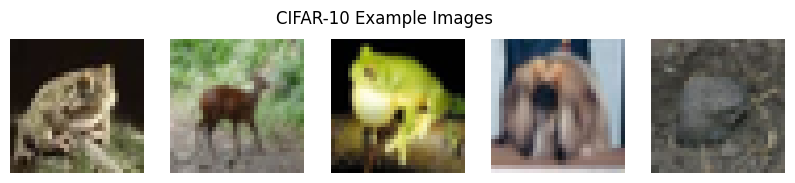

In [4]:
# Get one batch of training images
dataiter = iter(cifar_train_loader)
images, labels = next(dataiter)

# Convert images to numpy for display
images = images.numpy()

# Display 5 images
fig, axes = plt.subplots(1, 5, figsize=(10,2))
for idx in np.arange(5):
    axes[idx].imshow((np.transpose(images[idx], (1,2,0))))
    axes[idx].axis('off')
plt.suptitle('CIFAR-10 Example Images')

## Classifier

Now lets define our neural network.  For this we will download a ResNet-18 model (that means it contains 18 layers) that has been pretrained on ImageNet.  We will then swap out the final linear layers so that instead of classifying 1000 classes, it is classifying 10.

In [5]:
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        
        # Download ResNet18 model and replace last layer
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=512),
        )
        self.resnet.eval()
        
        # Add a final MLP to be run after the ResNet18 model
        self.final_layers = nn.Sequential(
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10),
        )

    def forward(self, x):
        x = self.resnet(x)
        pred = self.final_layers(x)
        return pred
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classifier = CustomResNet()
classifier = classifier.to(device)

Using cache found in C:\Users\hgm1g14/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\hgm1g14\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hgm1g14\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

Now lets train ours model, making sure to track the validation loss and accuracy through out.  As is standard for classifiers, we will use binary cross entropy loss.

In [6]:
# Hyperparameters
epochs  = 4
total_classes = 10
learning_rate = 0.0001

# Training loop objects
loss_bce = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

# Define loss history objects
train_losses = []
validation_losses = []

# Main training loop
for e in range(epochs):
    
    # TRAINING
    epoch_train_losses = []
    for i, data in tqdm(enumerate(cifar_train_loader), total=len(cifar_train_loader)):
        # Every data instance is an input + label pair
        images, labels = data
        one_hot_labels = F.one_hot(labels, total_classes)
        images, one_hot_labels = images.to(device), one_hot_labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        preds  = classifier(images.float())
        
        # Compute the loss and its gradients
        loss = loss_bce(preds, one_hot_labels.float())
        epoch_train_losses.append(loss.item()) # Save results
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
    # Save and print loss
    train_losses.append(sum(epoch_train_losses) / len(epoch_train_losses))
    print("Epoch:", e, "- Training Loss:", train_losses[-1])

    # VALIDATION
    epoch_validation_losses = []
    validation_predicted_labels = np.array([])
    validation_ground_truth_labels = np.array([])
    for i, data in tqdm(enumerate(cifar_test_loader), total=len(cifar_test_loader)):
                # Every data instance is an input + label pair
        images, labels = data
        one_hot_labels = F.one_hot(labels, total_classes)
        images, one_hot_labels = images.to(device), one_hot_labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        preds  = classifier(images.float())
        
        # Compute the loss and its gradients
        loss = loss_bce(preds, one_hot_labels.float())
        epoch_validation_losses.append(loss.item())
        
        # Save results
        validation_predicted_labels = np.concatenate((validation_predicted_labels, torch.argmax(preds, dim=1).cpu().detach()))
        validation_ground_truth_labels = np.concatenate((validation_ground_truth_labels, torch.argmax(one_hot_labels, dim=1).cpu().detach()))   
    
    validation_losses.append(sum(epoch_validation_losses) / len(epoch_validation_losses))
    print("Epoch:", e, "- Validation Loss:", validation_losses[-1])
    print('Validation Set Accuracy:', ((len(validation_ground_truth_labels) - np.count_nonzero(validation_predicted_labels - validation_ground_truth_labels)) / len(validation_ground_truth_labels)) * 100, '%')
    

100%|██████████| 500/500 [00:10<00:00, 47.84it/s]


Epoch: 0 - Training Loss: 0.21754831951856612


100%|██████████| 100/100 [00:01<00:00, 77.25it/s]


Epoch: 0 - Validation Loss: 0.14826874129474163
Validation Set Accuracy: 68.26 %


100%|██████████| 500/500 [00:10<00:00, 49.27it/s]


Epoch: 1 - Training Loss: 0.1259953627586365


100%|██████████| 100/100 [00:01<00:00, 75.81it/s]


Epoch: 1 - Validation Loss: 0.1282355224341154
Validation Set Accuracy: 73.71 %


100%|██████████| 500/500 [00:10<00:00, 48.83it/s]


Epoch: 2 - Training Loss: 0.10442508803308011


100%|██████████| 100/100 [00:01<00:00, 74.69it/s]


Epoch: 2 - Validation Loss: 0.10963922142982482
Validation Set Accuracy: 77.75 %


100%|██████████| 500/500 [00:10<00:00, 49.00it/s]


Epoch: 3 - Training Loss: 0.08783335307240486


100%|██████████| 100/100 [00:01<00:00, 75.42it/s]

Epoch: 3 - Validation Loss: 0.10934578128159046
Validation Set Accuracy: 78.3 %


Finally, lets plot our loss curves.

Text(0.5, 1.0, 'CIFAR-10 Classification Training Loss')

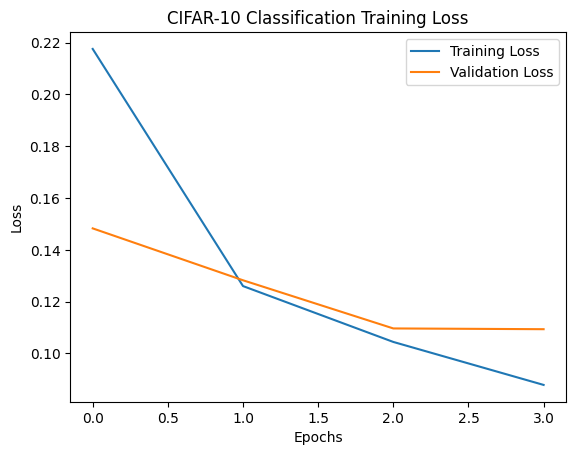

In [11]:
plt.plot(train_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CIFAR-10 Classification Training Loss')